In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
pc1 = np.loadtxt('pc1_obs_iso_new2.txt')
pc2 = np.loadtxt('pc2_obs_iso_new2.txt')


In [3]:
stackmax=200
H1=np.zeros((stackmax,pc1.shape[0]-stackmax+1))
H2=np.zeros((stackmax,pc2.shape[0]-stackmax+1))

H1_tmp=np.zeros((stackmax,pc1.shape[0]-stackmax+1))
H2_tmp=np.zeros((stackmax,pc2.shape[0]-stackmax+1))
print(H1.shape)

for k in range(stackmax):
    H1_tmp[k,:] = pc1[k:len(pc1)-(stackmax-1-k)]
    H2_tmp[k,:] = pc2[k:len(pc2)-(stackmax-1-k)]
    
    

    
H1 = H1_tmp 
H2 = H2_tmp 

H = np.vstack((H1,H2))

print(H.shape)


(200, 15672)
(400, 15672)


In [4]:
U, S, VT = np.linalg.svd(H,full_matrices=0)
V=VT.T
print(V.shape)
#print(S)

(15672, 400)


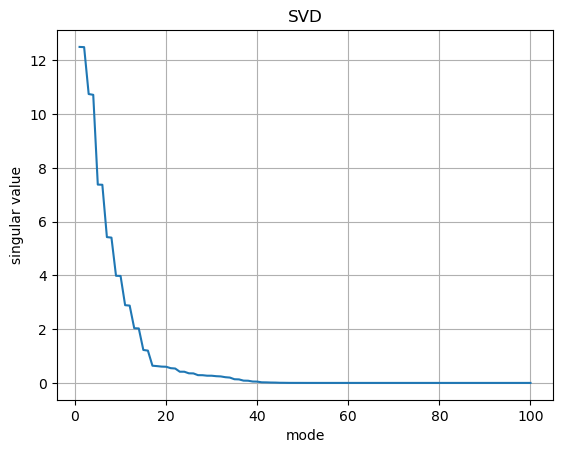

In [5]:
k=np.linspace(1, 100, 100)
var=S**2/sum(S**2)*100
fig, ax = plt.subplots()
ax.plot(k[0:100], var[0:100])

ax.set(xlabel='mode', ylabel='singular value',
       title='SVD')
ax.grid()
plt.savefig("MJO_SVD.pdf") 


In [6]:
print(sum(var[0:40]))

99.91611203079027


# building Koopman model

In [7]:
r  = 50 #
r2 = 10
dt = 1
dV = (1/(12*dt))*(-V[4:,0:r] + 8*V[3:-1,0:r] - 8*V[1:-3,0:r] + V[:-4,0:r])
#dV = (1/(12*dt))*(-V[4:,:] + 8*V[3:-1,:] - 8*V[1:-3,:] + V[:-4,:])
V2  = V[2:-2,0:r]
#V2  = V[2:-2,:]
print(dV.shape)
print(V2.shape)
print(len(V))

(15668, 50)
(15668, 50)
15672


In [8]:
Xi = np.linalg.lstsq(V2[0:10000,:],dV[0:10000,:],rcond=None)[0]
A2  = Xi[:(r-r2),:(r-r2)].T
#B2  = Xi[-r2:,:(r-r2)].T
B2  = Xi[r-r2:r,:r-r2].T
#B2=np.reshape(B2,(16,1))
print(A2.shape)
print(B2.shape)

(40, 40)
(40, 10)


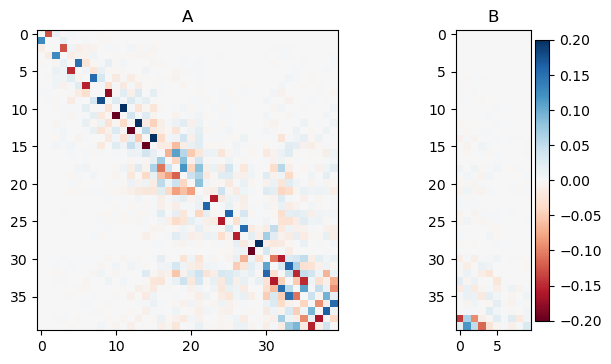

In [9]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[5, 1.56])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(A2, aspect='equal', cmap=plt.get_cmap('RdBu'),vmin=-0.2, vmax=0.2)
ax0.set(title='A')

ax1 = plt.subplot(gs[1])
im = ax1.imshow(B2, aspect='equal', cmap=plt.get_cmap('RdBu'), vmin=-0.2, vmax=0.2)
ax1.set(title='B')
fig.colorbar(im, ax=ax1)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6)
                    
plt.savefig("matrix_of_control_model.pdf") 


# model validation

In [10]:
from scipy.signal import lsim
from scipy.signal import lti

n_delays = stackmax-1
t=np.arange(0,len(pc1))

nlag=1000
N=10

ypred_n=np.zeros((nlag,2,N))
yreal_n=np.zeros((nlag,2,N))


Ur = U[:, : r]
sr = S[: r]
VrT = VT[: r, :]
Vr = VrT.T

ur = Ur[:, :-r2] @ np.diag(sr[:-r2])


In [ ]:
print(Vr[t0_2:,-r2:].shape)

In [12]:
for i in range(0,N):
    t0_2=10000+i*200
    t0=n_delays*1+t0_2
    y0 = (
        # np.linalg.inv(np.diag(self.svals[: self.svd_rank - 1]))
        # @
        np.linalg.pinv(ur)
        @ H[:,t0_2].T
     )

    

    sys = lti(
        #Xi[:(r-r2),:(r-r2)].T,
        #Xi[-r2:,:(r-r2)].reshape(r-r2, r2),
        A2,
        B2,
        ur,
        np.zeros((stackmax*2, r2)),
        )


    tout2, ypred2, xpred2 = lsim(sys, U=Vr[t0_2:t0_2+nlag,-r2:], T=t[t0:t0+nlag]-t[t0], X0=y0)
    
    ypred_n[:,0,i]=ypred2[:,stackmax-1]
    ypred_n[:,1,i]=ypred2[:,-1]
    
    yreal_n[:,0,i]=H[stackmax-1,t0_2:t0_2+nlag]
    yreal_n[:,1,i]=H[-1,t0_2:t0_2+nlag]
    
    

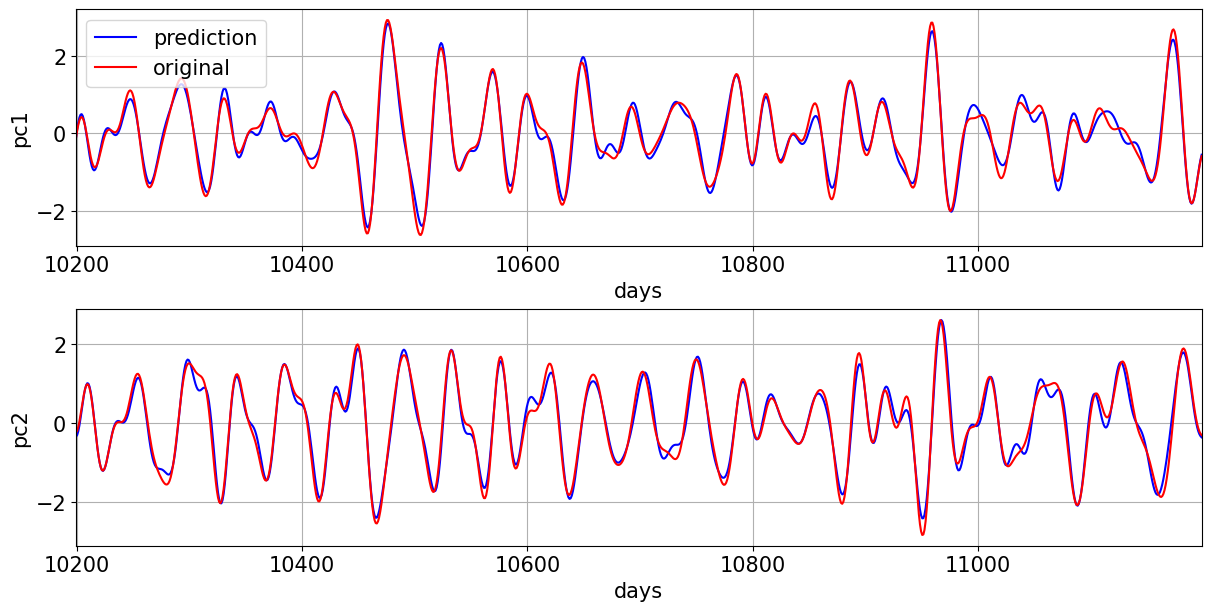

In [20]:
k=np.linspace(0, nlag, nlag)+10000+n_delays
fig, ax = plt.subplots(2,1,figsize=(12,6),layout='constrained')
#ax.plot(k, rmse, k, k*0+np.sqrt(2.0))

ax[0].plot(k, ypred_n[:,0,0],'-b',label='prediction')
ax[0].plot(k, yreal_n[:,0,0],'-r',label='original')
ax[0].set_xlim([10000+n_delays, 10000+n_delays+nlag])
ax[0].set_xlabel('days', fontsize=15)
ax[0].set_ylabel('pc1',fontsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].grid()
ax[0].legend(fontsize=15)

ax[1].plot(k, ypred_n[:,1,0],'-b',label='prediction')
ax[1].plot(k, yreal_n[:,1,0],'-r',label='original')
ax[1].set_xlim([10000+n_delays, 10000+n_delays+nlag])
ax[1].set_xlabel('days', fontsize=15)
ax[1].set_ylabel('pc2',fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].grid()
#ax[1].legend(fontsize=15)


plt.savefig("output_of_control_model.pdf") 



# characteristics of forcing

In [21]:
print(B2.shape)
print(VrT.shape)

(40, 10)
(50, 15672)


In [22]:
forcing=B2 @ VrT[-r2:,:]

print(forcing.shape)

(40, 15672)


In [23]:
np.savetxt('MJO_rmm_forcing.txt',forcing)


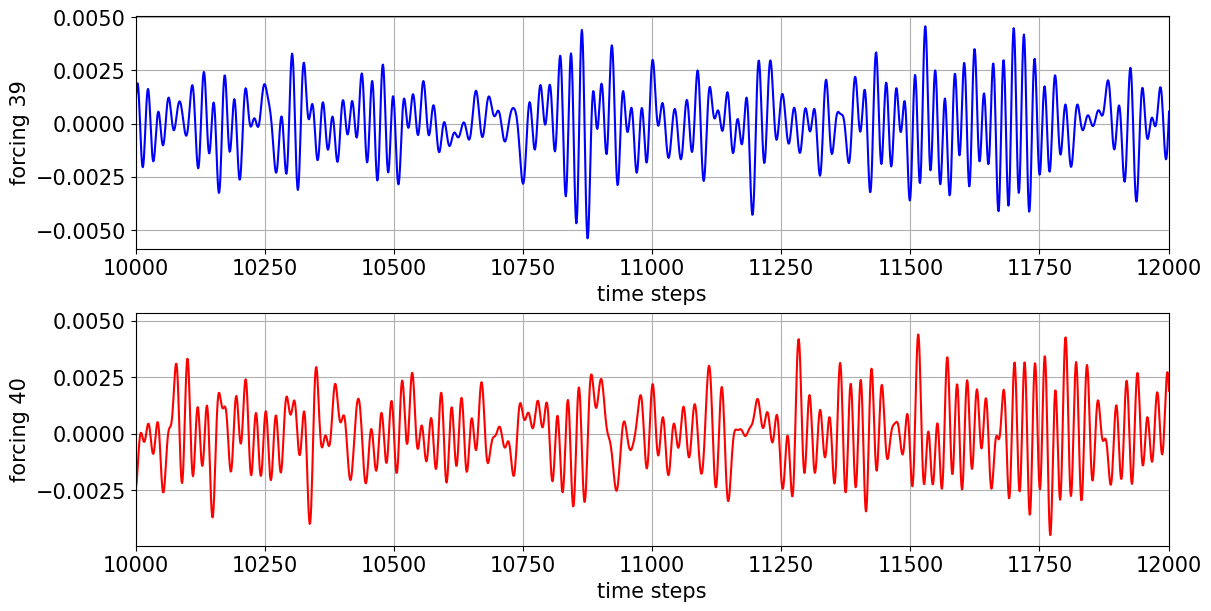

In [26]:
tt=np.linspace(0, 3999, 4000)+10000
fig, ax = plt.subplots(2,1,figsize=(12,6),layout='constrained')
#ax.plot(k, rmse, k, k*0+np.sqrt(2.0))
ax[0].plot(tt, forcing[-2,10000:14000],'-b')
ax[0].set_xlabel('time steps', fontsize=15)
ax[0].set_ylabel('forcing 39',fontsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_xlim([10000, 12000])
ax[0].grid()

ax[1].plot(tt, forcing[-1,10000:14000],'-r')
ax[1].set_xlabel('time steps', fontsize=15)
ax[1].set_ylabel('forcing 40',fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_xlim([10000, 12000])
ax[1].grid()

plt.savefig("forcing_time_series.pdf") 


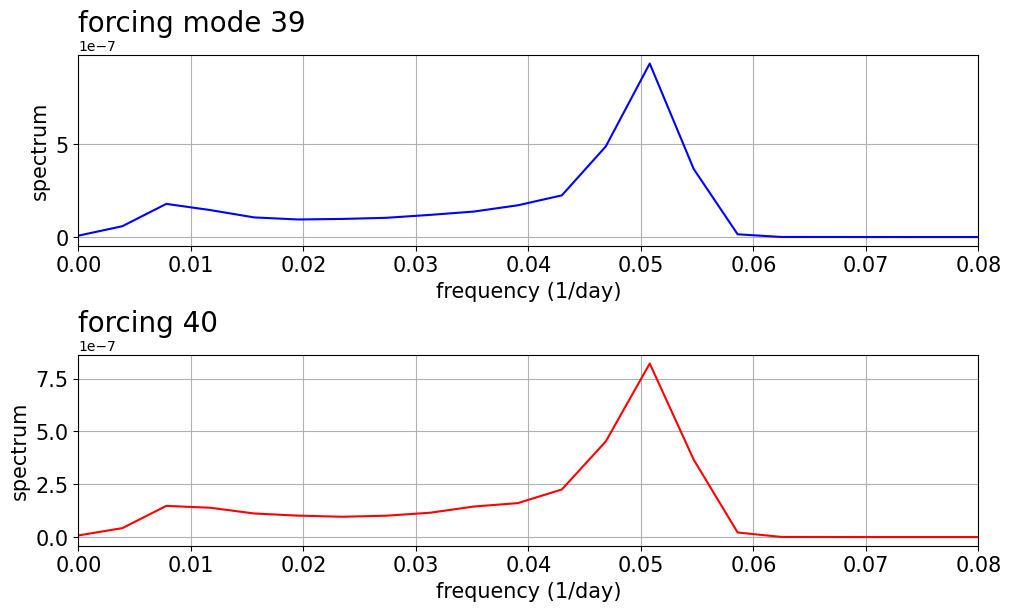

In [29]:
from scipy import signal

fig, ax = plt.subplots(2, 1,figsize=(10,6),layout='constrained')

#f, Pxx_den = signal.welch(VrT[-2,:])
#f1, Pxx_den1 = signal.welch(VrT[-1,:])
f, Pxx_den = signal.welch(forcing[-2,:],scaling='spectrum')
f1, Pxx_den1 = signal.welch(forcing[-1,:],scaling='spectrum')


ax[0].plot(f,Pxx_den,'-b')
#ax[0].semilogy(f,Pxx_den)
ax[0].set_xlim([0, 0.08])
ax[0].set_title('forcing mode 39 ', loc='left',fontsize=20) 
ax[0].set_xlabel('frequency (1/day)', fontsize=15)
ax[0].set_ylabel('spectrum',fontsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].grid()


ax[1].plot(f1,Pxx_den1,'-r')
#ax[1].semilogy(f1,Pxx_den1)
ax[1].set_xlim([0, 0.08])
ax[1].set_xlim([0, 0.08])
ax[1].set_title('forcing 40', loc='left',fontsize=20) 
ax[1].set_xlabel('frequency (1/day)', fontsize=15)
ax[1].set_ylabel('spectrum',fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].grid()

plt.savefig("spectrum_of_forcing.pdf") 
